# Assessing the 'Hb-likeness' of short peptides

In [2]:
import sys, os
from collections import Counter

os.environ["PATH"] += r";C:/Users/macraild/Anaconda3/envs/ideomDB/"
os.environ["PATH"] += r";C:/Users/macraild/Anaconda3/envs/ideomDB/Library\mingw-w64\bin"
os.environ["PATH"] += r";C:/Users/macraild/Anaconda3/envs/ideomDB/Library\usr\bin"
os.environ["PATH"] += r";C:/Users/macraild/Anaconda3/envs/ideomDB/Library\bin"
os.environ["PATH"] += r";C:/Users/macraild/Anaconda3/envs/ideomDB/Scripts"

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

from Bio import SeqIO 

In [30]:
# Set the __file__ variable for this notebook. Drop this line if converting to a module
__file__ = os.path.join(os.path.abspath(''), 'Hb_peptide_analysis.ipynb')

In [32]:
aa_formulas = {'Gly': {'C':2, 'H':5, 'N':1, 'O':2},
               'Ala': {'C':3, 'H':7, 'N':1, 'O':2},
               'Ser': {'C':3, 'H':7, 'N':1, 'O':3},
               'Pro': {'C':5, 'H':9, 'N':1, 'O':2},
               'Val': {'C':5, 'H':11, 'N':1, 'O':2},
               'Thr': {'C':4, 'H':9, 'N':1, 'O':3},
               'Cys': {'C':3, 'H':7, 'N':1, 'O':2, 'S':1},
               'Leu': {'C':6, 'H':13, 'N':1, 'O':2},
               'Ile': {'C':6, 'H':13, 'N':1, 'O':2},
               'Asn': {'C':4, 'H':8, 'N':2, 'O':3},
               'Asp': {'C':4, 'H':7, 'N':1, 'O':4},
               'Gln': {'C':5, 'H':10, 'N':2, 'O':3},
               'Lys': {'C':6, 'H':14, 'N':2, 'O':2},
               'Glu': {'C':5, 'H':9, 'N':1, 'O':4},
               'Met': {'C':5, 'H':11, 'N':1, 'O':2, 'S':1},
               'His': {'C':6, 'H':9, 'N':3, 'O':2},
               'Phe': {'C':9, 'H':11, 'N':1, 'O':2},
               'Arg': {'C':6, 'H':14, 'N':4, 'O':2},
               'Tyr': {'C':9, 'H':11, 'N':1, 'O':3},
               'Trp': {'C':11, 'H':12, 'N':2, 'O':2}
              }

aa_exact_mass = {'Gly': 75.03203,
                 'Ala': 89.04768,
                 'Ser': 105.04259,
                 'Pro': 115.06333,
                 'Val': 117.07898,
                 'Thr': 119.05824,
                 'Cys': 121.01975,
                 'Leu': 131.09463,
                 'Ile': 131.09463,
                 'Asn': 132.05349,
                 'Asp': 133.03751,
                 'Gln': 146.06914,
                 'Lys': 146.10553,
                 'Glu': 147.05316,
                 'Met': 149.05105,
                 'His': 155.06948,
                 'Phe': 165.07898,
                 'Arg': 174.11168,
                 'Tyr': 181.07389,
                 'Trp': 204.08988
                }

In [33]:
# A mapping of mass to peptide sequence, for identification of isomers:

import itertools, collections

aas = list(aa_exact_mass.keys())

peptides_by_mass = collections.defaultdict(list)

for N in [1,2,3,4,5,6]:
    for seq in itertools.combinations_with_replacement(aas, N):
        mass = sum([aa_exact_mass[aa] for aa in seq]) - 18.01056*(N-1)
        peptides_by_mass[int(mass*500)/500].append('/'.join(seq))
        

In [34]:
aas = "ACDEFGHIKLMNPQRSTVWY"
one2three = {"A": "Ala",
             "C": "Cys",
             "D": "Asp",
             "E": "Glu",
             "F": "Phe",
             "G": "Gly",
             "H": "His",
             "I": "Ile",
             "K": "Lys",
             "L": "Leu",
             "M": "Met",
             "N": "Asn",
             "P": "Pro",
             "Q": "Gln",
             "R": "Arg",
             "S": "Ser",
             "T": "Thr",
             "V": "Val",
             "W": "Trp",
             "Y": "Tyr"}
three2one = {v:k for k,v in one2three.items()}

In [35]:
class countPepInSeq(object):
    """Count the number of occurances of peptides in a protein sequence.
    
    init with a target protein sequence, and call with pd.Series an ms1-defined 3-letter id as 'name'
    """
    def __init__(self, seq):
        self.seq = seq
        self._sub_strings = {}
    def _calc_sub_strings(self, length):
        self._sub_strings[length] = [sorted(self.seq[i:i+length]) for i in range(len(self.seq)-length)]
    def __call__(self, pep):
        pep = pep.split('/')
        length = len(pep)
        if not length in self._sub_strings:
            self._calc_sub_strings(length)
        mass = sum([aa_exact_mass[aa] for aa in pep]) - (len(pep)-1)*18.01056
        count = 0
        counted = []
        for isomer in peptides_by_mass[int(mass*500)/500]:
            isomer = sorted(isomer.split('/'))
            if isomer in counted:
                continue
            pepOneLett = [three2one[aa] for aa in isomer]
            count += self._sub_strings[length].count(sorted(pepOneLett))
            counted.append(isomer)
        return count


In [36]:
class countSequencedPepInSeq(countPepInSeq):
    """Subclass to consider the fact that we have ms2-based sequences for a subset of peptides.
    
    init with a target protein sequence, and call with pd.Series with an ms2-defined 1-letter sequence 
    as 'sequence' and an ms1-defined 3-letter id as 'name'
    """
    def __call__(self, pep_series):
        count = 0
        if pd.isna(pep_series['sequence']):
            # No ms2 sequence, so consider all isomers of ms1 ID:
            pep = pep_series['name']
            pep = pep.split('/')
            length = len(pep)
            if not length in self._sub_strings:
                self._calc_sub_strings(length)
            mass = sum([aa_exact_mass[aa] for aa in pep]) - (len(pep)-1)*18.01056
            counted = []
            for isomer in peptides_by_mass[int(mass*500)/500]:
                isomer = sorted(isomer.split('/'))
                if isomer in counted:
                    continue
                pepOneLett = [three2one[aa] for aa in isomer]
                count += self._sub_strings[length].count(sorted(pepOneLett))
                counted.append(isomer)
        else:
            pep = pep_series['sequence']
            length = len(pep)
            if not length in self._sub_strings:
                self._calc_sub_strings(length)
            count = self._sub_strings[length].count(sorted(pep))
        return count

In [37]:
# Load identified peptides:
combined_data = pd.read_excel(os.path.join(os.path.dirname(__file__), "comnined-analysis-v3.xlsx"), sheet_name='Sheet3')

ms2peptides = pd.read_csv(os.path.join(os.path.dirname(__file__), "MS2_peptides.csv"))
ms2peptides = ms2peptides.dropna(subset=['name', 'HB'])
ms2peptides = ms2peptides.drop(columns=['Unnamed: 3']).rename(columns={'Unnamed: 5':'sequence'})

In [38]:
ms2peptides.loc[11,'name'] = "Val/Ser"
ms2peptides.loc[16,'name'] = "Thr/Pro"
ms2peptides.loc[24,'name'] = "Ala/His"
ms2peptides.loc[32,'name'] = "Asp/Val"

In [39]:
combined_data = combined_data.merge(ms2peptides[['name', 'sequence', 'HB']], on='name', how='left')

In [40]:
# The blood-stage Pf spectral library:
pf_seen = pd.read_excel(os.path.join(os.path.dirname(__file__), "Peptides_proteins.xlsx"), sheet_name='Pf_peptide_counts')
hs_seen = pd.read_excel(os.path.join(os.path.dirname(__file__), "Peptides_proteins.xlsx"), sheet_name='Hs_peptide_counts')

In [41]:
# Normalised peptide counts for each protein in the library:
for protein in SeqIO.parse(os.path.join(os.path.dirname(__file__), "PfHs_PlasmoDB-45_Pfalciparum3D7_plus_UP00005640.fasta"), 'fasta'):
    if protein.id.startswith('PF3D7_'):
        acc = protein.id
        count = combined_data.loc[(combined_data['P-VALUE inhibitor/control']<0.05)&(combined_data['P-VALUE kd/control']<0.05)].apply(countSequencedPepInSeq(protein.seq), axis=1)
        pf_seen.loc[pf_seen.BGSInferenceId==acc, 'NormalisedPeptideCounts'] = count.sum()/len(protein.seq)
    else:
        if protein.id.startswith('tr|'):
            acc = protein.id.split('|')[-1].split('_')[0]
        elif protein.id.startswith('sp|'):
            acc = protein.id.split('|')[1]
        count = combined_data.loc[(combined_data['P-VALUE inhibitor/control']<0.05)&(combined_data['P-VALUE kd/control']<0.05)].apply(countSequencedPepInSeq(protein.seq), axis=1)
        if hs_seen.BGSInferenceId.str.contains(acc).sum() > 1:
            print(f"Multiple matches to UniprotID {acc} from {protein.id}")
        hs_seen.loc[hs_seen.BGSInferenceId.str.contains(acc), 'NormalisedPeptideCounts'] = count.sum()/len(protein.seq)

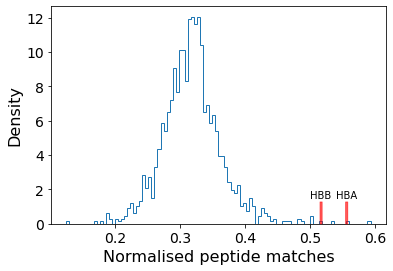

In [42]:
plt.hist(pd.concat([hs_seen.NormalisedPeptideCounts, pf_seen.NormalisedPeptideCounts]), bins=100, density=True, histtype='step', label='Hs')
for prot, pos in [('HBA',(0.55633,1.5)), ('HBB',(0.517,1.5))]:
    plt.annotate(prot, xy=(pos[0], 0), xycoords='data', xytext=pos, textcoords='data', 
                 arrowprops={'width':2,'headwidth':2,'headlength':0.1,'ec':'red','fc':'red','alpha':0.6,'connectionstyle':'arc3'}, horizontalalignment='center')
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel("Normalised peptide matches", fontdict={'size':16})
plt.ylabel("Density", fontdict={'size':16})
plt.savefig(os.path.join(os.path.dirname(__file__), "Hb_NormalisedPeptideCounts_MS2update.png"))
plt.savefig(os.path.join(os.path.dirname(__file__), "Hb_NormalisedPeptideCounts_MS2update.svg"))